In [ ]:
!unzip *.zip -d /content/data

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
 extracting: /content/data/s6_057_A_r.png  
 extracting: /content/data/s6_057_B_L.png  
 extracting: /content/data/s6_057_B_R.png  
 extracting: /content/data/s6_057_C_L.png  
 extracting: /content/data/s6_057_C_R.png  
 extracting: /content/data/s6_057_D_L.png  
 extracting: /content/data/s6_057_D_R.png  
 extracting: /content/data/s6_057_E_L.png  
 extracting: /content/data/s6_057_E_R.png  
 extracting: /content/data/s6_057_F_L.png  
 extracting: /content/data/s6_057_F_R.png  
 extracting: /content/data/s6_058_A_L.png  
 extracting: /content/data/s6_058_A_R.png  
 extracting: /content/data/s6_058_B_L.png  
 extracting: /content/data/s6_058_B_R.png  
 extracting: /content/data/s6_058_C_L.png  
 extracting: /content/data/s6_058_C_R.png  
 extracting: /content/data/s6_058_D_L.png  
 extracting: /content/data/s6_058_D_R.png  
 extracting: /content/data/s6_058_E_L.png  
 extracting: /content/data/s6_058_E_R.png  
 extracting

In [ ]:
import glob
from PIL import Image, ImageOps

img_count = 0

for im_path in glob.glob("/content/data/*.png"):
    img_count += 1

print("Number of images unzipped:", img_count)

Number of images unzipped: 9529


In [ ]:
from PIL import Image
import numpy as np
import os

# Name of a new folder that will be made
new_folder_name = "nowy_folder"

# Path to a new folder in /content
new_folder_path = os.path.join("/content", new_folder_name)

# Creating new folder if it doesnt exist
os.makedirs(new_folder_path, exist_ok=True)

# Path to a folder with .png images
folder_path = "/content/data"

# List of images
images = []

# Converting all the files in a folder
for filename in os.listdir(folder_path):
    if filename.endswith(".png"):
        # Loading an image and converting it to a grayscale image
        img = Image.open(os.path.join(folder_path, filename)).convert('L')

        # Numpy array convertion
        img_array = np.array(img)

        # Adding an image to an array
        images.append(img_array)

# Converting list to an array
images = np.array(images)

# Saving data to previously created folder
np.save(os.path.join(new_folder_path, 'images.npy'), images)

In [ ]:
from sklearn.model_selection import train_test_split

# Reading data from a file
images = np.load('/content/nowy_folder/images.npy')

# Preparing data - normalization of pixel values to the range [0, 1]
images = images.astype('float32') / 255.0

# Spliting data into a training and test sets (80% train, 20% test)
train_images, test_images = train_test_split(images, test_size=0.2, random_state=42)



In [ ]:
from tensorflow.keras.layers import Dense, Input, Flatten,\
                                    Reshape, LeakyReLU as LR,\
                                    Activation, Dropout
from tensorflow.keras.models import Model, Sequential
from matplotlib import pyplot as plt
from IPython import display # If using IPython, Colab or Jupyter
import numpy as np

In [ ]:
# Using previously saved data
(x_train, x_test) = train_images, test_images
y_train, y_test = None, None  # In case of using labels

# Checking the dimensions of the data
print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (7623, 30, 25)
x_test shape: (1906, 30, 25)


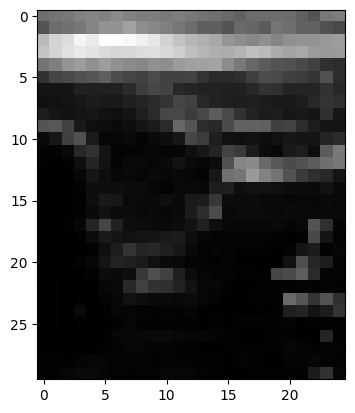

In [ ]:
# Plotting image data from x_train
plt.imshow(x_train[0], cmap = "gray")
plt.show()

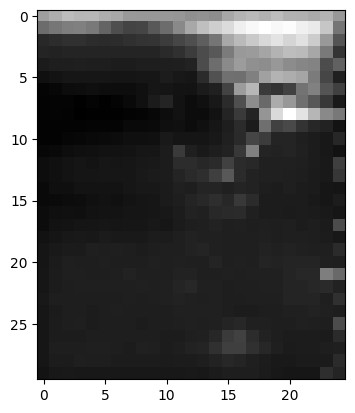

In [ ]:
# Plotting image data from x_train
plt.imshow(x_test[0], cmap = "gray")
plt.show()

In [ ]:
# Latent size refers to the dimensionality of the latent space in generative models, influencing the complexity of captured patterns.
LATENT_SIZE = 64

In [ ]:
encoder = Sequential([
    Flatten(input_shape=(30, 25)),  # Adjusting input shape in this case an ultrasound image size (height,width)
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(256),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(64),
    Activation('relu'),
    Dropout(0.5),
    Dense(LATENT_SIZE),
    Activation('relu')
])

In [ ]:
decoder = Sequential([
    Dense(64, input_shape=(LATENT_SIZE,)),
    Activation('relu'),
    Dropout(0.5),
    Dense(128),
    Activation('relu'),
    Dropout(0.5),
    Dense(256),
    Activation('relu'),
    Dropout(0.5),
    Dense(512),
    Activation('relu'),
    Dropout(0.5),
    Dense(np.prod((30, 25))),  # Adjusting output shape
    Activation("sigmoid"),
    Reshape((30, 25))  # Adjusting output shape
])

In [ ]:
# Image shape
img = Input(shape = (30, 25))

In [ ]:
# Encoding of an input image into a latent vector using an encoder, followed by decoding to reconstruct the output image
latent_vector = encoder(img)
output = decoder(latent_vector)

In [ ]:
# Implementing optimizer and loss function
model = Model(inputs = img, outputs = output)
model.compile("nadam", loss = "binary_crossentropy")

In [ ]:
# Number of epochs
EPOCHS = 60

1/1 [==============================] - 0s 22ms/step


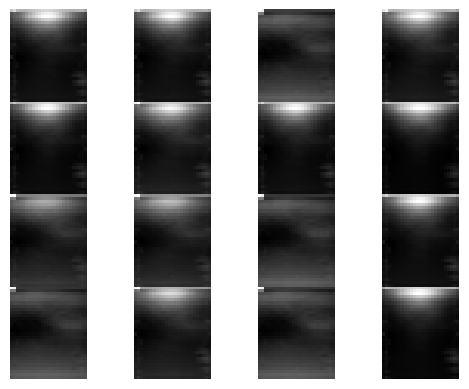

----------- EPOCH 59 -----------
239/239 [==============================] - 5s 22ms/step - loss: 0.5102


In [ ]:
for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)

    # Check the length of x_test
    test_size = len(x_test)

    # Ensure that the range for random indices is within the size of x_test
    rand_indices = np.random.randint(0, test_size, 16)

    # Reshape rand using rand_indices
    rand = x_test[rand_indices].reshape((4, 4, 1, 30, 25))

    display.clear_output()  # If imported display from IPython

    for i in range(4):
        for j in range(4):
            axs[i, j].imshow(model.predict(rand[i, j])[0], cmap="gray")
            axs[i, j].axis("off")

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


1/1 [==============================] - 0s 24ms/step


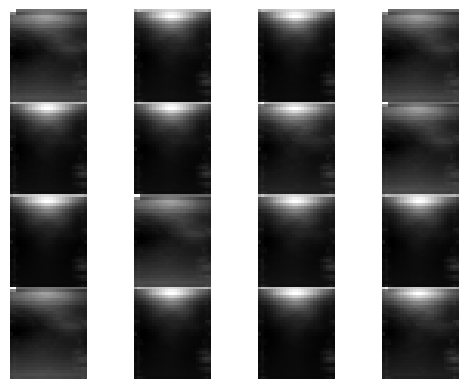

----------- EPOCH 59 -----------
239/239 [==============================] - 6s 27ms/step - loss: 0.5107


In [ ]:
import os

# Directory to save decoded images
save_dir = "/content/decoded"
os.makedirs(save_dir, exist_ok=True)

decoded_images = []  # To store decoded images as NumPy arrays

for epoch in range(EPOCHS):
    fig, axs = plt.subplots(4, 4)

    # Check the length of x_test
    test_size = len(x_test)

    # Ensure that the range for random indices is within the size of x_test
    rand_indices = np.random.randint(0, test_size, 16)

    # Reshape rand using rand_indices
    rand = x_test[rand_indices].reshape((4, 4, 1, 30, 25))

    display.clear_output()  # If imported display from IPython

    for i in range(4):
        for j in range(4):
            # Predict and get the decoded image
            decoded_image = model.predict(rand[i, j])[0]

            # Save the decoded image as a NumPy array
            decoded_images.append(decoded_image)

            # Display the image
            axs[i, j].imshow(decoded_image, cmap="gray")
            axs[i, j].axis("off")

    # Convert the list of decoded images to a NumPy array
    decoded_images_np = np.array(decoded_images)

    # Save the NumPy array
    np.save(os.path.join(save_dir, f"decoded_images_epoch_{epoch}.npy"), decoded_images_np)

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    print("-----------", "EPOCH", epoch, "-----------")
    model.fit(x_train, x_train)


1/1 [==============================] - 0s 34ms/step


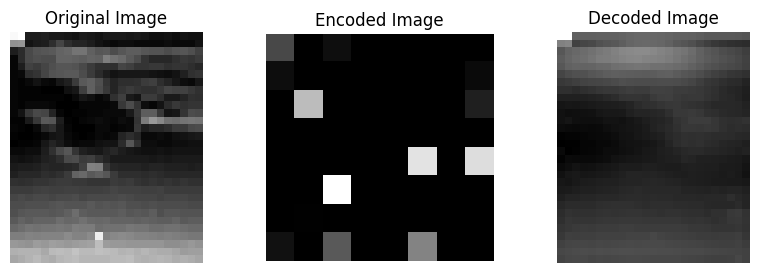

In [ ]:
# Generate a new random image for comparison
new_rand_indices = np.random.randint(0, len(x_test), 1)
new_rand = x_test[new_rand_indices].reshape((1, 30, 25, 1))

# Encode the new random image
encoded_image = model.layers[1].predict(new_rand)  # Assuming the encoder is the first layer after input

# Decode the encoded image
decoded_image = model.layers[-1].predict(encoded_image)

# Plot the original, encoded, and decoded images for comparison
fig, axs = plt.subplots(1, 3, figsize=(10, 3))

# Original Image
axs[0].imshow(new_rand[0, :, :, 0], cmap="gray")
axs[0].axis("off")
axs[0].set_title("Original Image")

# Encoded Image
axs[1].imshow(encoded_image.reshape((8, 8)), cmap="gray")  # Assuming the encoded image has a shape of (8, 8)
axs[1].axis("off")
axs[1].set_title("Encoded Image")

# Decoded Image

axs[2].imshow(decoded_image[0, :, :], cmap="gray")
axs[2].axis("off")
axs[2].set_title("Decoded Image")


plt.show()


Loaded decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



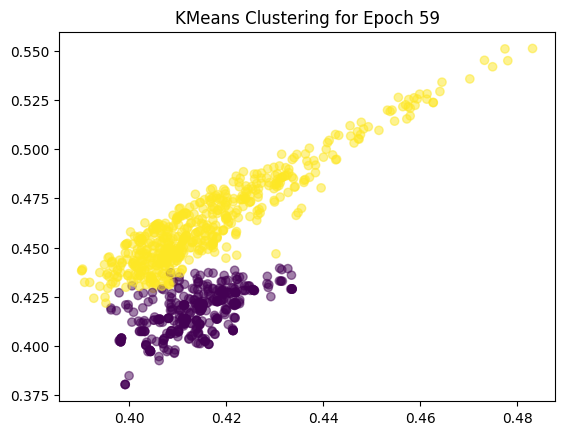

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Load the decoded images from epoch 59
epoch_number = 59
file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

if os.path.exists(file_path):
    decoded_images_epoch = np.load(file_path)
    print(f"Loaded decoded images from epoch {epoch_number}.")

    # Reshape each decoded image to 2D (flatten each image into a vector)
    decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

    # Specify the number of clusters
    num_clusters = 2  # Adjust based on specific use case

    # Apply KMeans clustering
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(decoded_images_flat)

    # Visualize the clustering results (example for two clusters)
    plt.scatter(decoded_images_flat[:, 0], decoded_images_flat[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f'KMeans Clustering for Epoch {epoch_number}')
    plt.show()


else:
    print(f"File not found: {file_path}")


Loaded decoded images from epoch 1.
Silhouette Score for Epoch 1: 0.6794923543930054


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



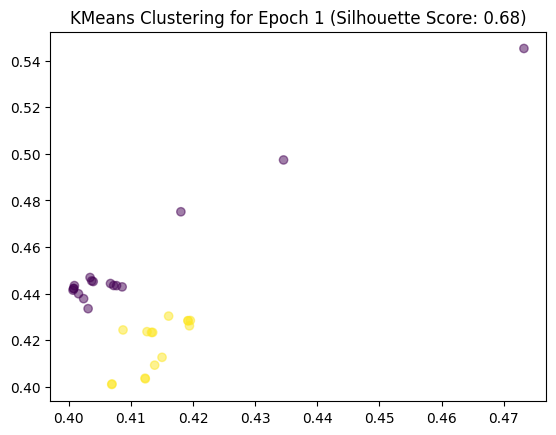

Loaded decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for Epoch 25: 0.6504001617431641


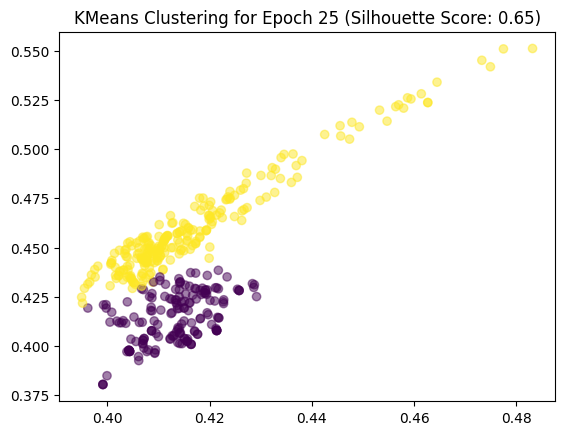

Loaded decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



Silhouette Score for Epoch 59: 0.6702805757522583


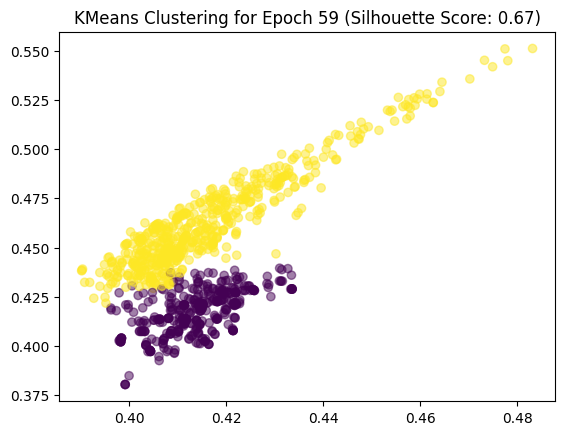

In [ ]:
import os
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

def cluster_and_visualize(epoch_number, num_clusters=2):
    # Directory where decoded images are saved
    decoded_dir = "/content/decoded"

    # Load the decoded images from the specified epoch
    file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(file_path):
        decoded_images_epoch = np.load(file_path)
        print(f"Loaded decoded images from epoch {epoch_number}.")

        # Reshape each decoded image to 2D (flatten each image into a vector)
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Apply KMeans clustering
        kmeans = KMeans(n_clusters=num_clusters, random_state=42)
        cluster_labels = kmeans.fit_predict(decoded_images_flat)

        # Calculate silhouette score
        silhouette_avg = silhouette_score(decoded_images_flat, cluster_labels)
        print(f"Silhouette Score for Epoch {epoch_number}: {silhouette_avg}")

        # Visualize the clustering results
        plt.scatter(decoded_images_flat[:, 0], decoded_images_flat[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
        plt.title(f'KMeans Clustering for Epoch {epoch_number} (Silhouette Score: {silhouette_avg:.2f})')
        plt.show()

    else:
        print(f"File not found: {file_path}")

# Call the function for epochs 1, 25, and 59
for epoch in [1, 25, 59]:
    cluster_and_visualize(epoch)


Loaded decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



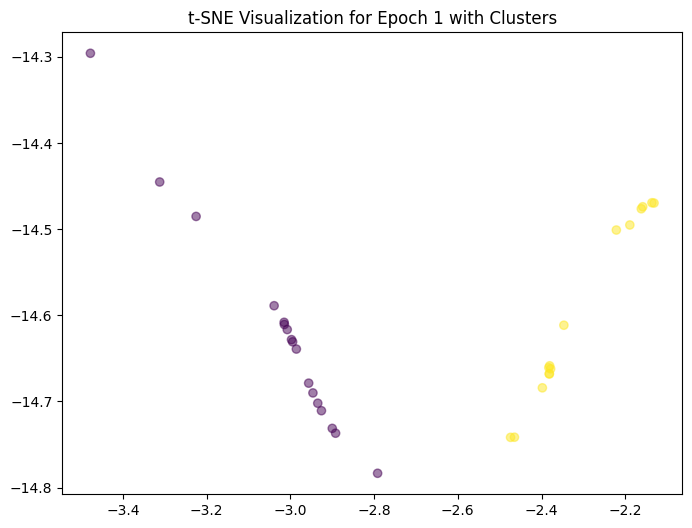

Loaded decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



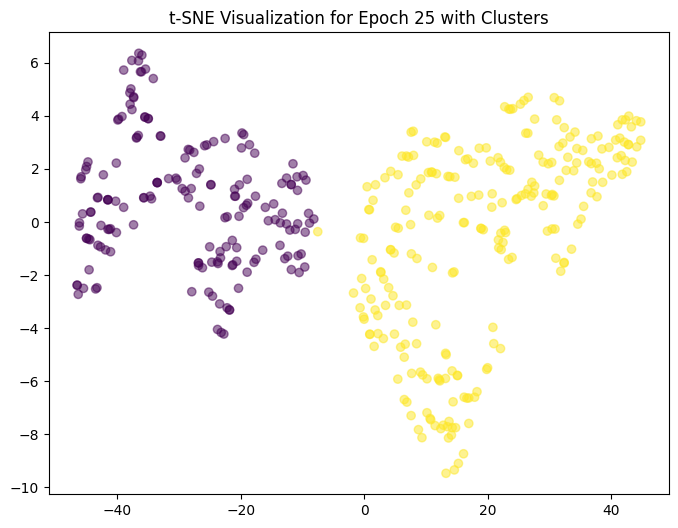

Loaded decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



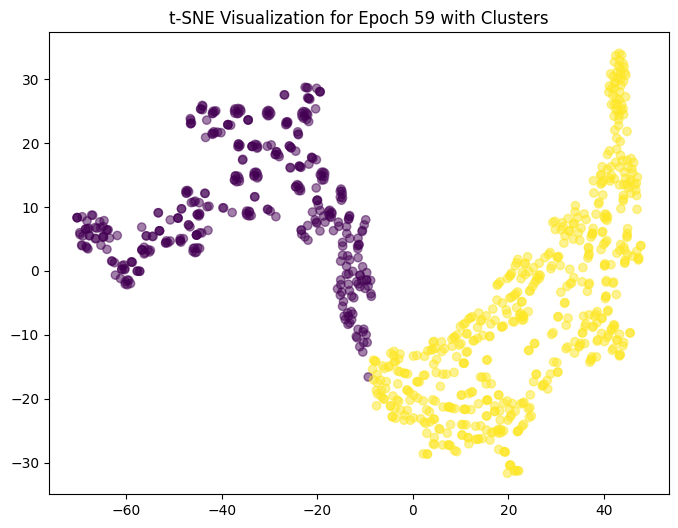

In [ ]:
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_tsne(decoded_images_flat, cluster_labels, epoch_number):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embedded_data = tsne.fit_transform(decoded_images_flat)

    # Visualize the t-SNE plot with cluster labels
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f't-SNE Visualization for Epoch {epoch_number} with Clusters')
    plt.show()

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the decoded images from the specified epoch
    file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(file_path):
        decoded_images_epoch = np.load(file_path)
        print(f"Loaded decoded images from epoch {epoch_number}.")

        # Reshape each decoded image to 2D (flatten each image into a vector)
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        cluster_labels = kmeans.fit_predict(decoded_images_flat)

        # Visualize t-SNE
        visualize_tsne(decoded_images_flat, cluster_labels, epoch_number)

    else:
        print(f"File not found: {file_path}")



Loaded decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



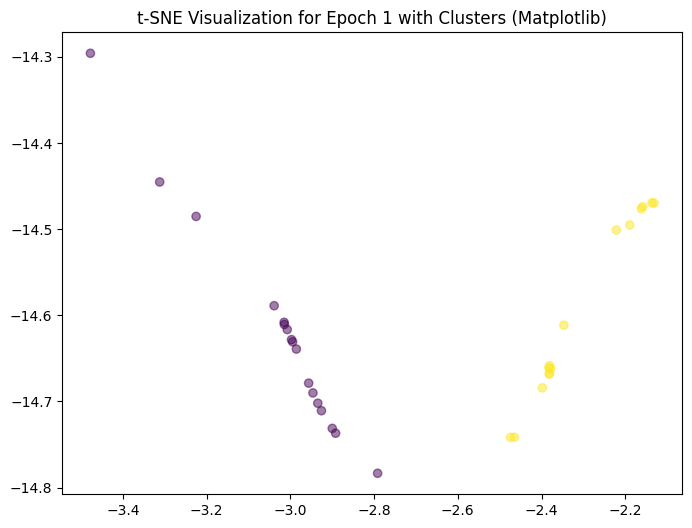

Loaded decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



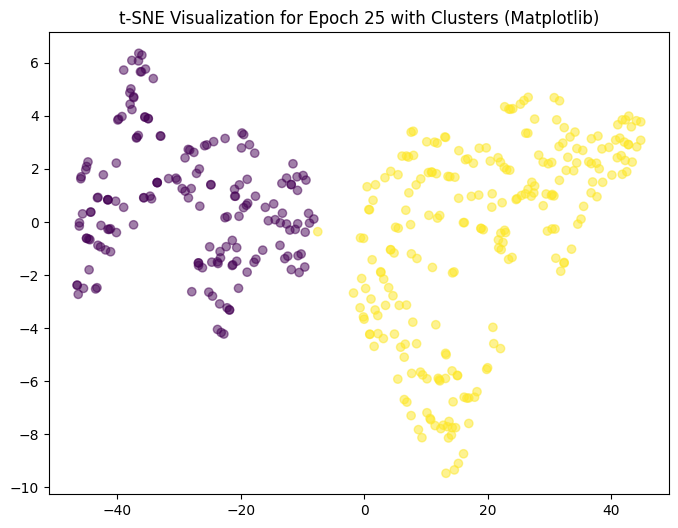

Loaded decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



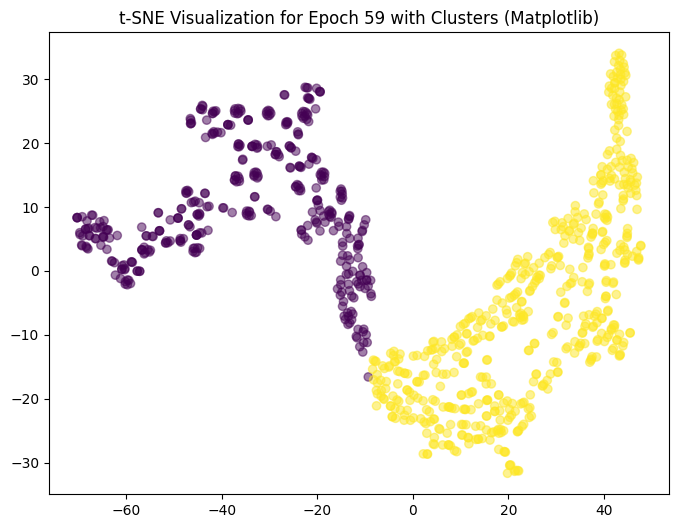

In [ ]:
import os
import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd

def visualize_tsne(decoded_images_flat, cluster_labels, epoch_number):
    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    embedded_data = tsne.fit_transform(decoded_images_flat)

    # Visualize the t-SNE plot with cluster labels using matplotlib
    plt.figure(figsize=(8, 6))
    plt.scatter(embedded_data[:, 0], embedded_data[:, 1], c=cluster_labels, cmap='viridis', alpha=0.5)
    plt.title(f't-SNE Visualization for Epoch {epoch_number} with Clusters (Matplotlib)')
    plt.show()

    # Visualize the t-SNE plot with cluster labels using Plotly
    df_tsne = pd.DataFrame({'X': embedded_data[:, 0], 'Y': embedded_data[:, 1], 'Cluster': cluster_labels})
    fig = px.scatter(df_tsne, x='X', y='Y', color='Cluster', opacity=0.7)
    fig.update_layout(title=f't-SNE Visualization for Epoch {epoch_number} with Clusters (Plotly)')
    fig.show()

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the decoded images from the specified epoch
    file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(file_path):
        decoded_images_epoch = np.load(file_path)
        print(f"Loaded decoded images from epoch {epoch_number}.")

        # Reshape each decoded image to 2D (flatten each image into a vector)
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        cluster_labels = kmeans.fit_predict(decoded_images_flat)

        # Visualize t-SNE using both Matplotlib and Plotly
        visualize_tsne(decoded_images_flat, cluster_labels, epoch_number)

    else:
        print(f"File not found: {file_path}")


Loaded decoded images from epoch 1.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



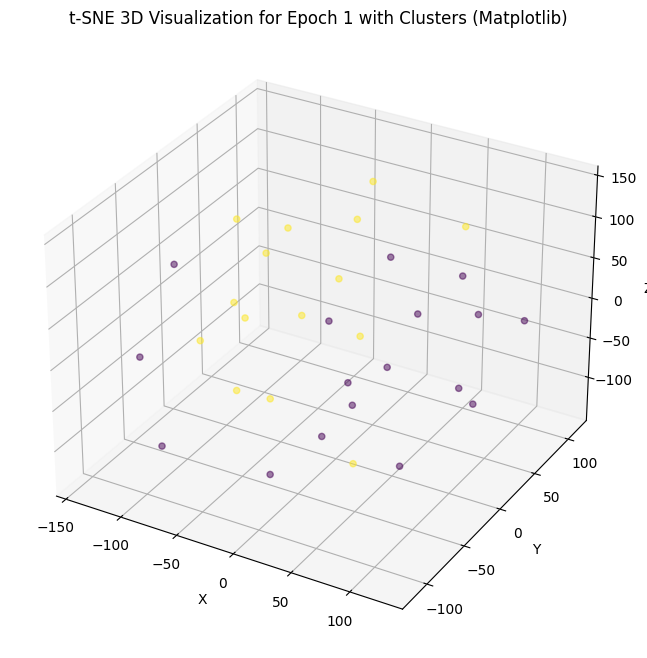

Loaded decoded images from epoch 25.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



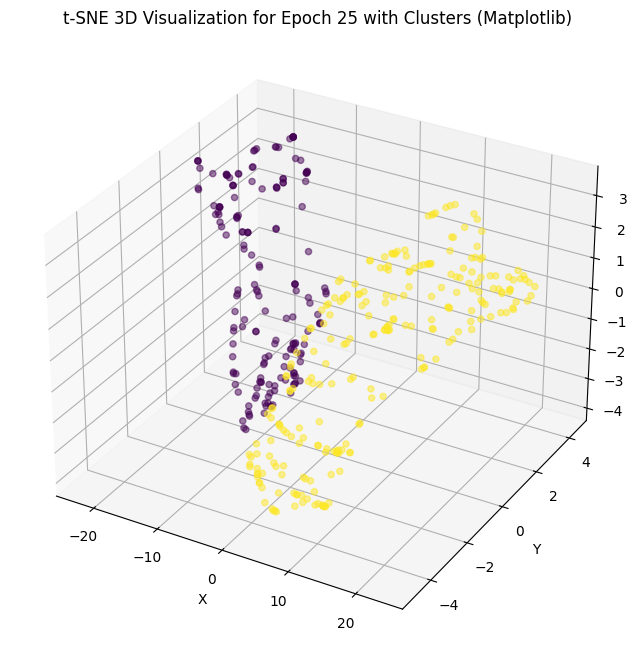

Loaded decoded images from epoch 59.


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



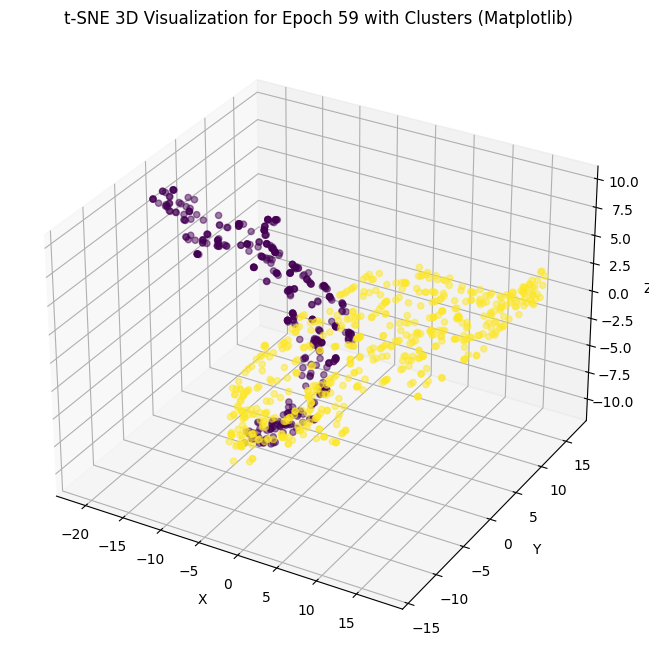

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def visualize_tsne_3d(decoded_images_flat, cluster_labels, epoch_number):
    # Apply t-SNE with 3D visualization
    tsne = TSNE(n_components=3, random_state=42)
    embedded_data = tsne.fit_transform(decoded_images_flat)

    # Visualize the 3D t-SNE plot with cluster labels using matplotlib
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c=cluster_labels, cmap='viridis', alpha=0.5)
    ax.set_title(f't-SNE 3D Visualization for Epoch {epoch_number} with Clusters (Matplotlib)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

    # Visualize the 3D t-SNE plot with cluster labels using Plotly
    df_tsne = pd.DataFrame({'X': embedded_data[:, 0], 'Y': embedded_data[:, 1], 'Z': embedded_data[:, 2], 'Cluster': cluster_labels})
    fig = px.scatter_3d(df_tsne, x='X', y='Y', z='Z', color='Cluster', opacity=0.7, title=f't-SNE 3D Visualization for Epoch {epoch_number} with Clusters (Plotly)')
    fig.show()

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the decoded images from the specified epoch
    file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(file_path):
        decoded_images_epoch = np.load(file_path)
        print(f"Loaded decoded images from epoch {epoch_number}.")

        # Reshape each decoded image to 1D (flatten each image into a vector)
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        cluster_labels = kmeans.fit_predict(decoded_images_flat)

        # Visualize 3D t-SNE using both Matplotlib and Plotly
        visualize_tsne_3d(decoded_images_flat, cluster_labels, epoch_number)

    else:
        print(f"File not found: {file_path}")


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



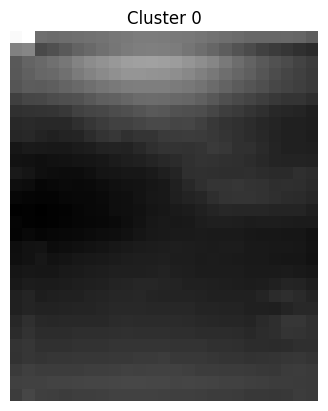

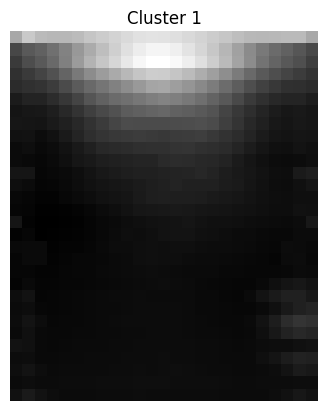

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epoch and clusters to visualize
epoch_number = 59
cluster_labels = kmeans.fit_predict(decoded_images_flat)

# Load the decoded image from the specified epoch
file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")
decoded_images_epoch = np.load(file_path)

# Iterate through each cluster and display a random image from that cluster
for cluster in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster)[0]
    random_index = random.choice(indices)

    # Display the selected image
    if len(decoded_images_epoch.shape) == 4:
        plt.imshow(decoded_images_epoch[random_index, :, :, 0], cmap="gray")
    elif len(decoded_images_epoch.shape) == 3:
        plt.imshow(decoded_images_epoch[random_index, :, :], cmap="gray")
    else:
        raise ValueError("Invalid shape for decoded_images_epoch")

    plt.title(f'Cluster {cluster}')
    plt.axis("off")
    plt.show()



/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



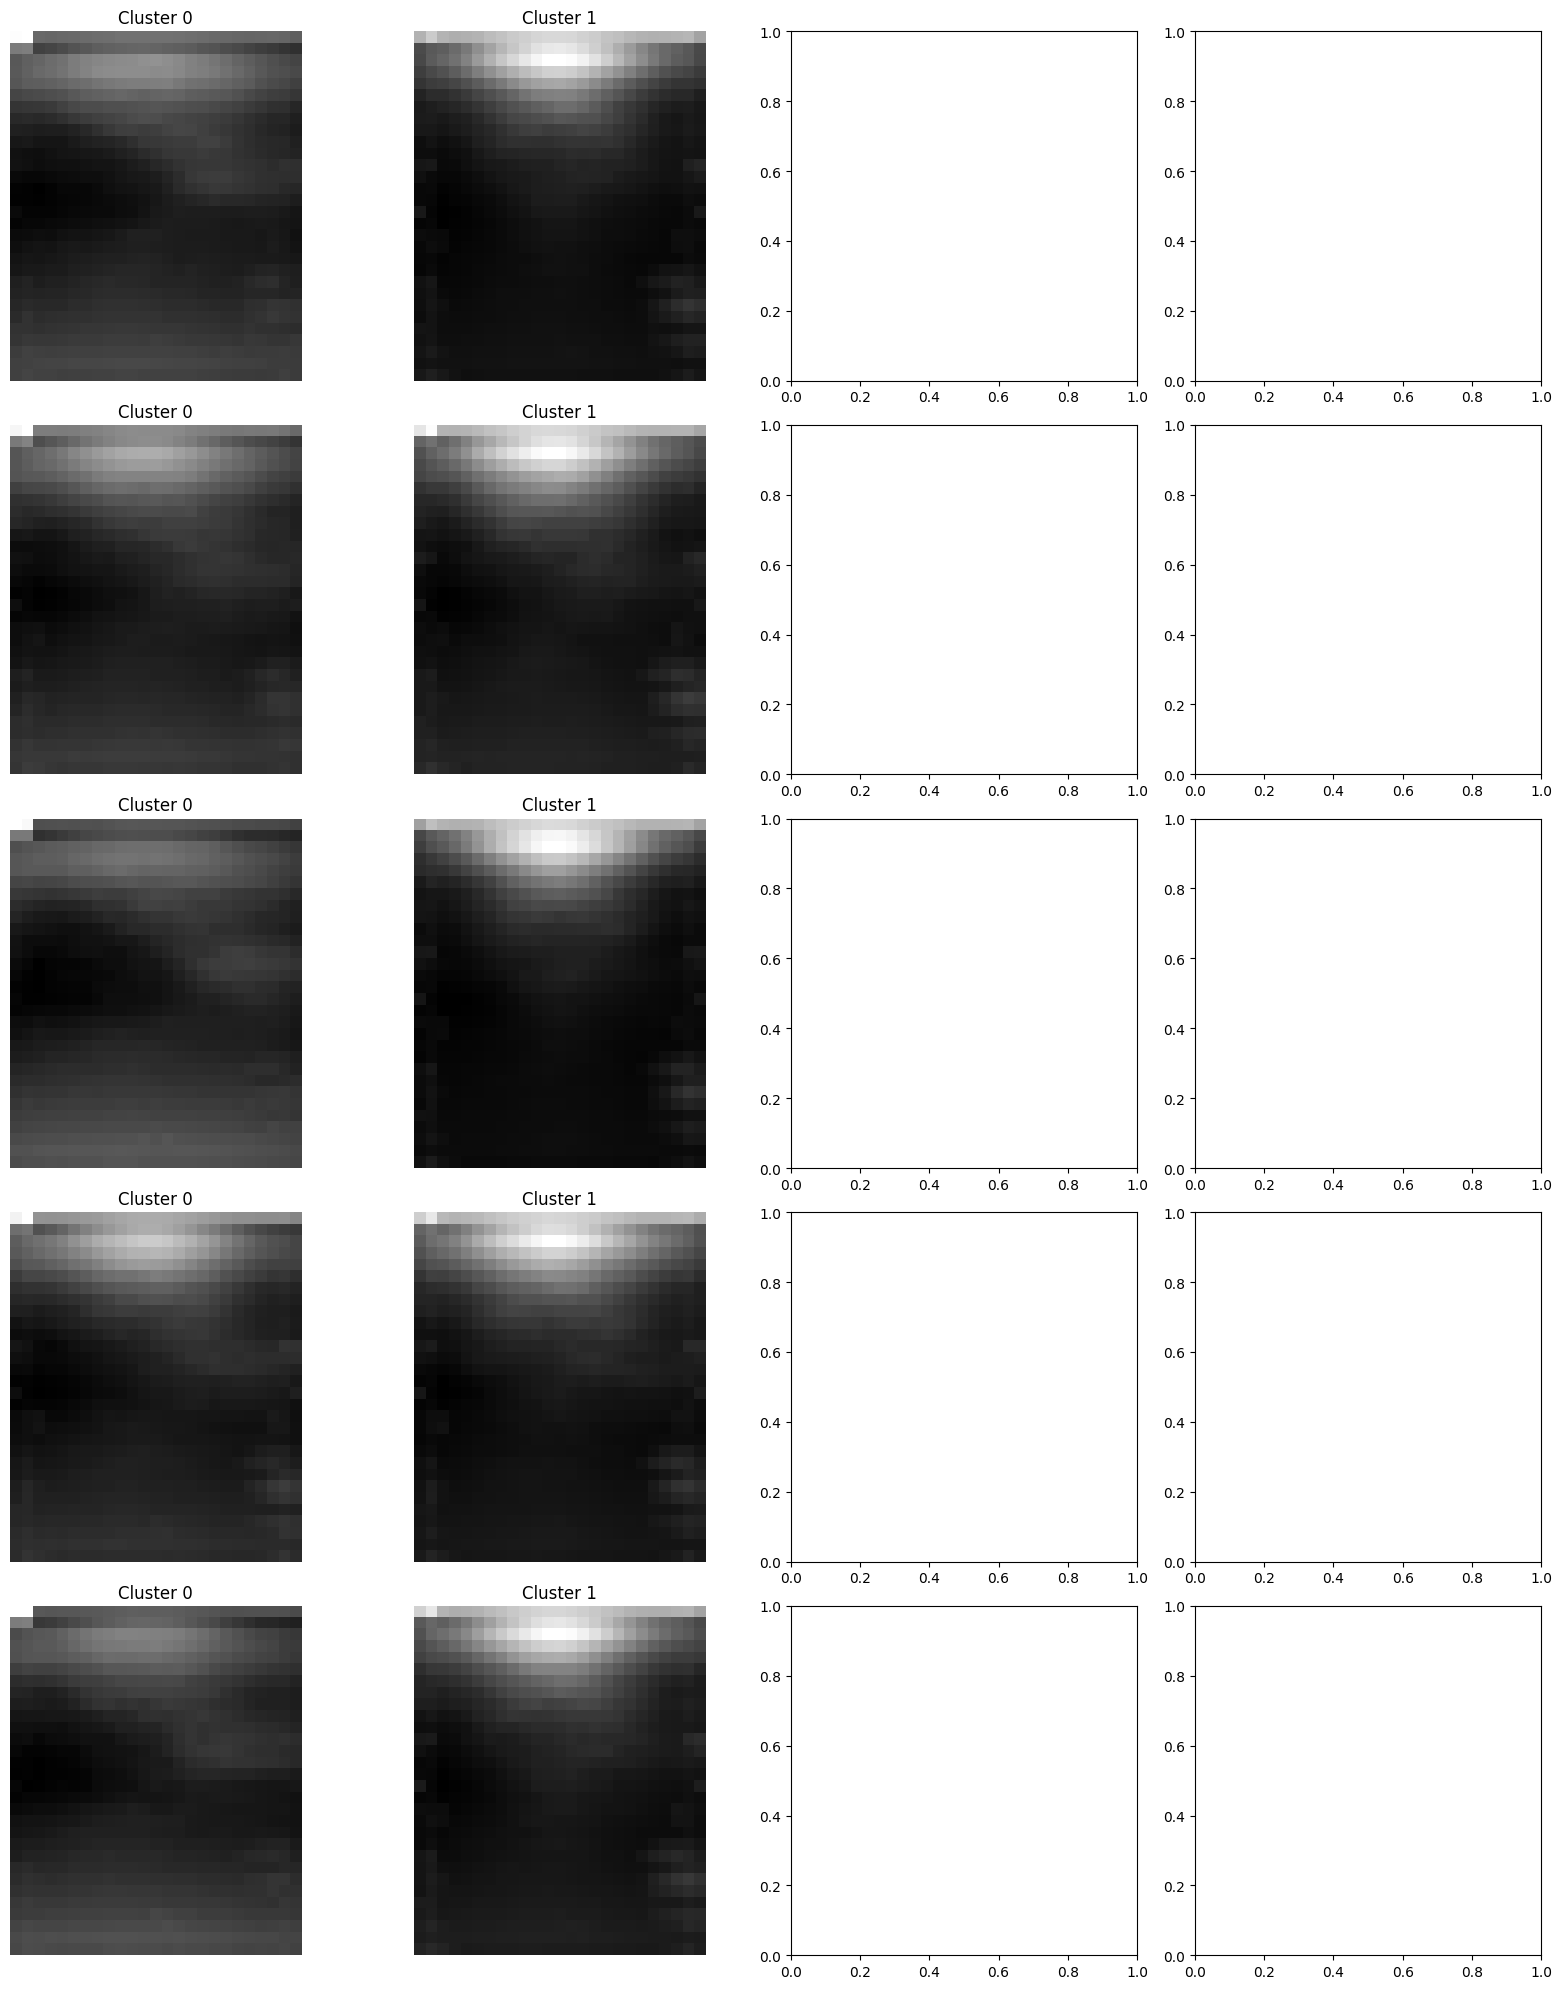

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import random

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epoch and clusters you want to visualize
epoch_number = 59
cluster_labels = kmeans.fit_predict(decoded_images_flat)

# Load the decoded image from the specified epoch
file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")
decoded_images_epoch = np.load(file_path)

# Set up subplots
fig, axs = plt.subplots(5, 4, figsize=(16, 20))

# Iterate through each cluster and display 5 random images from each cluster
for cluster in np.unique(cluster_labels):
    indices = np.where(cluster_labels == cluster)[0]
    random_indices = random.sample(indices.tolist(), min(5, len(indices)))

    # Plot images in the grid
    for i, index in enumerate(random_indices):
        ax = axs[i, cluster]

        if len(decoded_images_epoch.shape) == 4:
            ax.imshow(decoded_images_epoch[index, :, :, 0], cmap="gray")
        elif len(decoded_images_epoch.shape) == 3:
            ax.imshow(decoded_images_epoch[index, :, :], cmap="gray")
        else:
            raise ValueError("Invalid shape for decoded_images_epoch")

        ax.set_title(f'Cluster {cluster}')
        ax.axis("off")

# Adjust layout
plt.tight_layout()
plt.show()


Loaded decoded images from epoch 1.


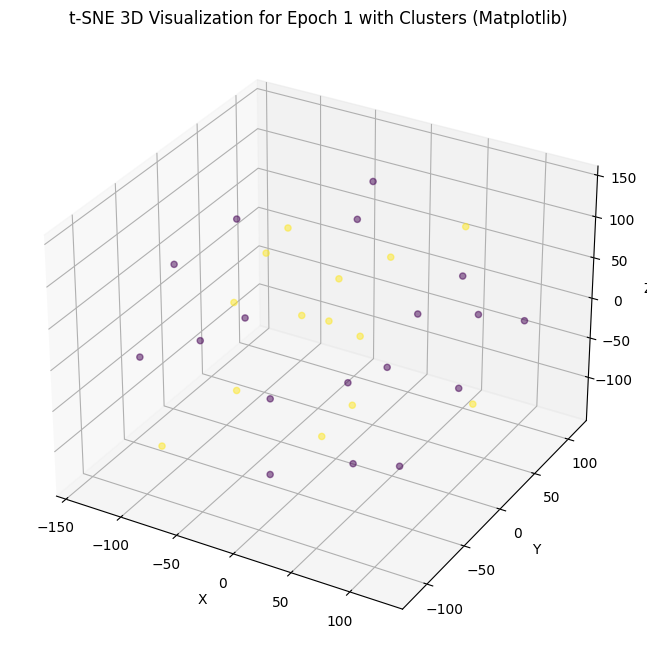

Loaded decoded images from epoch 25.


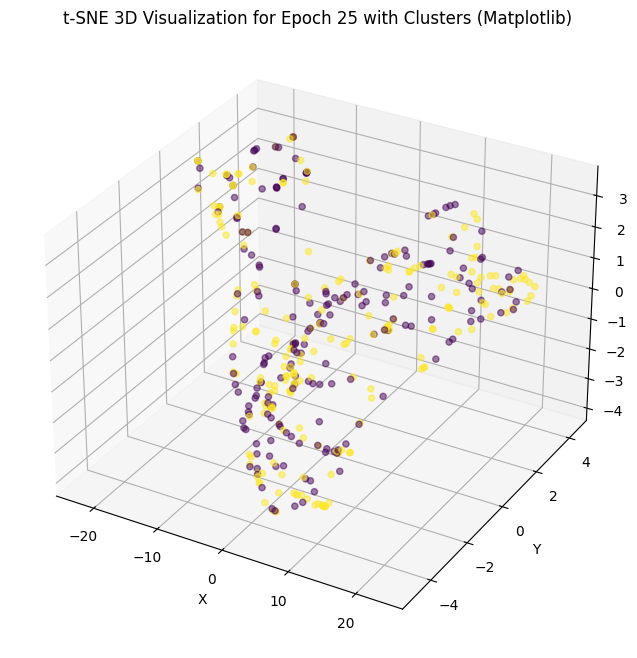

Loaded decoded images from epoch 59.


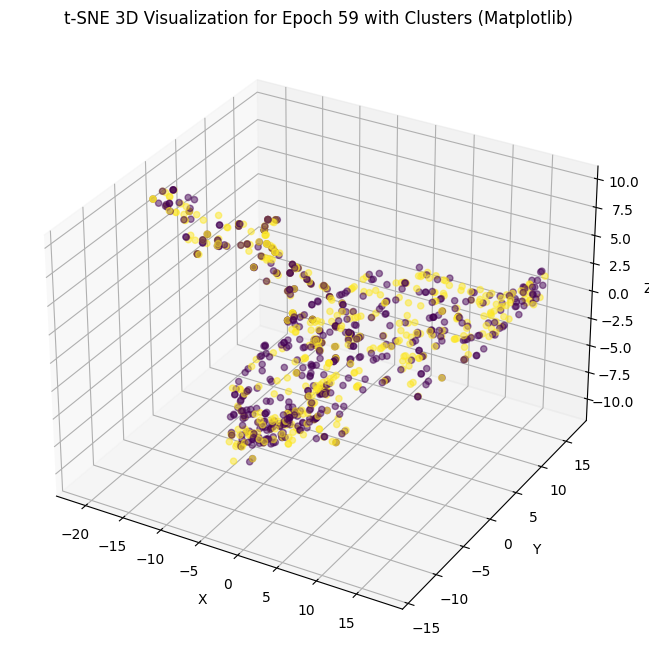

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

def visualize_tsne_3d(decoded_images_flat, cluster_labels, epoch_number):
    # Apply t-SNE with 3D visualization
    tsne = TSNE(n_components=3, random_state=42)
    embedded_data = tsne.fit_transform(decoded_images_flat)

    # Visualize the 3D t-SNE plot with cluster labels using matplotlib
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(embedded_data[:, 0], embedded_data[:, 1], embedded_data[:, 2], c=cluster_labels, cmap='viridis', alpha=0.5)
    ax.set_title(f't-SNE 3D Visualization for Epoch {epoch_number} with Clusters (Matplotlib)')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

    # Visualize the 3D t-SNE plot with cluster labels using Plotly
    df_tsne = pd.DataFrame({'X': embedded_data[:, 0], 'Y': embedded_data[:, 1], 'Z': embedded_data[:, 2], 'Cluster': cluster_labels})
    fig = px.scatter_3d(df_tsne, x='X', y='Y', z='Z', color='Cluster', opacity=0.7, title=f't-SNE 3D Visualization for Epoch {epoch_number} with Clusters (Plotly)')
    fig.show()

# Directory where decoded images are saved
decoded_dir = "/content/decoded"

# Specify the epochs to visualize
epochs_to_visualize = [1, 25, 59]

for epoch_number in epochs_to_visualize:
    # Load the decoded images from the specified epoch
    file_path = os.path.join(decoded_dir, f"decoded_images_epoch_{epoch_number}.npy")

    if os.path.exists(file_path):
        decoded_images_epoch = np.load(file_path)
        print(f"Loaded decoded images from epoch {epoch_number}.")

        # Reshape each decoded image to 1D (flatten each image into a vector)
        decoded_images_flat = decoded_images_epoch.reshape((-1, decoded_images_epoch.shape[1] * decoded_images_epoch.shape[2]))

        # Assuming you have cluster labels (replace this with your actual cluster labels)
        cluster_labels = np.random.randint(0, 2, size=len(decoded_images_flat))

        # Visualize 3D t-SNE using both Matplotlib and Plotly with specific clustering
        visualize_tsne_3d(decoded_images_flat, cluster_labels, epoch_number)

    else:
        print(f"File not found: {file_path}")

